In [12]:
# %%capture --no-stderr
%pip install -U langgraph transformers langsmith langchain-huggingface

  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/53/0f/c4802c26da60b84af1ee4a1d3013378da2354220aa2d0e766d07c5db1de2/langgraph-0.3.31-py3-none-any.whl.metadata
  Obtaining dependency information for langsmith from https://files.pythonhosted.org/packages/67/64/87a103a6a1cdca06559b09aa270e5dbfe018df4fd1b8327ce5a720441629/langsmith-0.3.32-py3-none-any.whl.metadata


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 3.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.30
    Uninstalling langsmith-0.3.30:
      Successfully uninstalled langsmith-0.3.30
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.3.29
    Uninstalling langgraph-0.3.29:
      Successfully uninstalled langgraph-0.3.29
Note: you may need to restart the kernel to use updated packages.


In [1]:
import getpass
import os
from langchain_nvidia import ChatNVIDIA


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("NVIDIA_API_KEY")

NVIDIA_API_KEY: ········


In [30]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from typing import List
from pydantic import BaseModel, Field
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from sentence_transformers import SentenceTransformer

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [31]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [32]:
import json
from pathlib import Path
from langchain.docstore.document import Document

def load_documents_from_json(directory_path):
    """Load documents from a directory containing JSON files."""
    documents = []
    for file_path in Path(directory_path).glob("*.json"):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                content = json.load(f)
                text = content.get("Scraped Text", "")
                # Decode any escape sequences like \u2013 (en dash) in the text
                text = text.encode('utf-8').decode('unicode_escape')
                metadata = {
                    "source": content.get("URL location", ""),
                    "last_modified": content.get("Last modification date", ""),
                    "change_frequency": content.get("Change frequency", ""),
                    "priority": content.get("Priority", "")
                }
                if text.strip():  # Only include documents with non-empty text
                    # Generate a unique ID for each document, e.g., using the file name
                    document_id = str(file_path.name)  # Using file name as the ID
                    documents.append(Document(page_content=text, metadata=metadata, id=document_id))
            except Exception as e:
                print(f"Failed to load {file_path.name}: {e}")
                continue  # Skip this file and move to the next one
    return documents

In [33]:
def update_vectorstore_from_scraped():
    global vectorstore, embeddings

    print("Loading documents from scraped_data_json...")
    new_documents = load_documents_from_json("scraped_data_json")

    if not new_documents:
        print("No documents found.")
        return "No documents found."

    try:
        vectorstore = FAISS.from_documents(new_documents, embeddings)
        vectorstore.save_local(vectorDB_name)
        print("Vectorstore updated from scraped JSON data.")
        return "Success"
    except Exception as e:
        print(f"Error while updating vectorstore: {e}")
        return "Error"

In [34]:
def load_and_search_docs(user_input, k=3):
    global vectorstore, embeddings
    if not vectorstore:
        load_vector_database(vectorDB_name)

    # Use the retriever with the full search space and a specified `k`
    retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": k})
    
    docs = retriever.get_relevant_documents(user_input)

    print(f"\n🔍 Query: {user_input}")
    for i, doc in enumerate(docs):
        metadata_str = doc.metadata if hasattr(doc, 'metadata') else "No metadata"
        print(f"\n📄 doc_{i} (source: {metadata_str}):\n{doc.page_content[:300]}...")

    return {f"doc_{i}": d.page_content for i, d in enumerate(docs)}


In [35]:
from langchain_core.messages import AIMessage

llm = ChatNVIDIA(base_url="https://integrate.api.nvidia.com/v1", model="meta/llama-3.3-70b-instruct")
def check_relevance_node(state):
    user_question = state["user_input"]
    docs = state["docs"]  # dict of key -> content

    relevant_docs = {}

    for key, content in docs.items():
        prompt = f"""
Question or email:
"{user_question}"

Document content:
{content}

Does this content provide any relevant information to answer the question?
Respond only with a "YES" or "NO" on the last line.
If absolutely uncertain, respond "NO". If slightly certain, respond "YES"
"""
        try:
            print(prompt)
            resp = llm.invoke(prompt)  # returns AIMessage
            print(resp)
            answer = resp.content.strip()
            # Check if the answer is YES or NO and act accordingly
            last_line = answer.split('\n')[-1].strip().upper()
            if last_line == "YES":
                relevant_docs[key] = content
                print(f"Document '{key}' is relevant!")
            else:
                print(f"Document '{key}' is not relevant.")

        except Exception as e:
            print(f"[Error] {key} relevance check failed:", e)

    # Store the relevant docs in the state for further use
    state["relevant_docs"] = relevant_docs
    print(f"Checked {len(docs)} docs. Found {len(relevant_docs)} relevant.")
    return state


/Users/adityavinodh/anaconda3/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:212: UserWarning: Found meta/llama-3.3-70b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [36]:
from langchain_core.messages import AIMessage

llm = ChatNVIDIA(base_url="https://integrate.api.nvidia.com/v1", model="meta/llama-3.3-70b-instruct")

def build_prompt_node(state):
    user_question = state["user_input"]
    relevant_docs = state.get("docs", {})

    if not relevant_docs:
        print("No relevant documents found. Skipping final prompt generation.")
        state["final_response"] = "Sorry, I couldn't find a relevant answer in the provided documents."
        return state

    combined_context = "\n\n---\n\n".join(
        f"Document {i+1}:\n{content}" for i, content in enumerate(relevant_docs.values())
    )

    final_prompt = f"""
You are an intelligent assistant.

Here is a question from the user:
"{user_question}"

Here are relevant pieces of context from various documents:
{combined_context}

Based on the above content, provide a complete and helpful answer to the user's question.
Be as specific and concise. If the content is not enough, say so clearly.
"""

    try:
        response = llm.invoke(final_prompt)
        final_answer = response.content.strip()
        state["final_response"] = final_answer
    except Exception as e:
        print("[Error] Failed to generate final response:", e)
        state["final_response"] = "An error occurred while generating the answer."

    return state


/Users/adityavinodh/anaconda3/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:212: UserWarning: Found meta/llama-3.3-70b-instruct in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [37]:
def generate_answer_node(state):
    final_answer = state.get("final_response", None)

    if not final_answer:
        print("No final response available to return.")
        state["answer"] = "Sorry, I couldn't generate an answer at this time."
    else:
        state["answer"] = final_answer

    return state


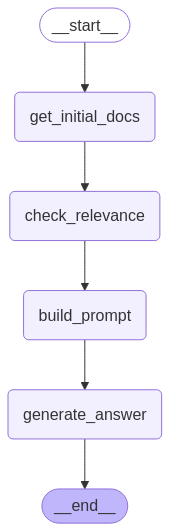

In [38]:
from langgraph.graph import StateGraph

builder = StateGraph(State)

builder.add_node("get_initial_docs", lambda state: {**state, "docs": load_and_search_docs(state["user_input"])})

builder.add_node("check_relevance", check_relevance_node)
builder.add_node("build_prompt", build_prompt_node)
builder.add_node("generate_answer", generate_answer_node)

builder.set_entry_point("get_initial_docs")
builder.add_edge("get_initial_docs", "check_relevance")
builder.add_edge("check_relevance", "build_prompt")
builder.add_edge("build_prompt", "generate_answer")

builder.set_finish_point("generate_answer")

graph = builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [23]:
import nltk
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from nltk.tokenize import sent_tokenize

# # Download punkt tokenizer once
# nltk.download('punkt')

# Define global variables for embeddings and model names
vectorstore = None
embeddings = None
model_name="sentence-transformers/all-MiniLM-L6-v2"
vectorDB_name = "raiss_site"

def initialize_embeddings():
    """Initialize the embedding model with remote code trust enabled."""
    global embeddings
    embeddings = HuggingFaceEmbeddings()

def create_vector_database(chunked_documents):
    """Create a Vector Database Base (VDB) from pre-processed document chunks."""
    global vectorstore
    try:
        # Ensure each chunked document is properly structured
        wrapped_documents = []
        for doc in chunked_documents:
            try:
                # Directly access page_content and metadata from Document
                if not isinstance(doc, Document):
                    print(f"Skipping document with id {doc.id} as it is not a Document object.")
                    continue  # Skip this document if it is not a Document object
                
                # Append valid Document objects
                wrapped_documents.append(doc)
            except Exception as e:
                print(f"Error processing document with id {doc.id}: {str(e)}")
                continue  # Skip this document if an error occurs

        # Create FAISS index and vector embeddings for chunks of data
        vectorstore = FAISS.from_documents(wrapped_documents, embeddings)

        # Save the vector database index locally
        vectorstore.save_local(vectorDB_name)

        return "Successfully created the vector database from chunked documents."
    except Exception as e:
        return f"Error creating vector database: {str(e)}"

def semantic_chunk_document(text, metadata=None, max_chunk_words=100):
    if metadata is None:
        metadata = {}

    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ""
    current_word_count = 0

    for sentence in sentences:
        words = sentence.split()
        if current_word_count + len(words) > max_chunk_words:
            chunks.append(Document(page_content=current_chunk.strip(), metadata=metadata))
            current_chunk = sentence
            current_word_count = len(words)
        else:
            current_chunk += " " + sentence
            current_word_count += len(words)

    if current_chunk:
        chunks.append(Document(page_content=current_chunk.strip(), metadata=metadata))

    return chunks

def semantic_chunk_all_documents(documents, max_chunk_words=100):
    all_chunks = []
    for doc in documents:
        chunks = semantic_chunk_document(doc.page_content, metadata=doc.metadata, max_chunk_words=max_chunk_words)
        all_chunks.extend(chunks)
    return all_chunks


# Step 1: Load documents from a local directory
documents_directory = "/Users/adityavinodh/Documents/sp25mps/raiss_ai/scraped_data_json"
raw_documents = load_documents_from_json(documents_directory)  

# Step 2: Apply semantic chunking
chunked_documents = semantic_chunk_all_documents(raw_documents, max_chunk_words=100)

# Step 3: Initialize embeddings model
initialize_embeddings()

# Step 4: Create the vector database
result_message = create_vector_database(chunked_documents)

print(result_message)


/var/folders/5z/c3rg13j54bdfj4dsnvyvgsyh0000gn/T/ipykernel_7783/326732280.py:19: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()


Successfully created the vector database from chunked documents.


In [24]:

    # # Example usage
# # Step 1: Load documents from a local directory
# documents_directory = "/Users/adityavinodh/Documents/sp25mps/raiss_ai/scraped_data_json"  # Update this to your local directory path
# chunked_documents = load_documents_from_json(documents_directory)

# # Step 2: Initialize embeddings model
# initialize_embeddings()

# # Step 3: Create the vector database

# result_message = create_vector_database(chunked_documents)

# print(result_message)

/var/folders/5z/c3rg13j54bdfj4dsnvyvgsyh0000gn/T/ipykernel_50628/1119709352.py:10: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()


Successfully created the vector database from chunked documents.


In [24]:
vectorstore.save_local(vectorDB_name)
# vectorstore = FAISS.load_local(vectorDB_name, embeddings, allow_dangerous_deserialization=True)



In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

vectorDB_name= "raiss_site"

def load_vector_database(vectorDB_name = vectorDB_name):
    global vectorstore
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    vectorstore = FAISS.load_local(vectorDB_name, embeddings, allow_dangerous_deserialization=True)


# Example user input
user_input = "Tell me about RAIS"

# Simulate initial state with only user input
state = {
    "user_input": user_input
}

# Step 1: Load and search documents dynamically
# This adds "docs" to the state
state = {
    **state,
    "docs": load_and_search_docs(state["user_input"])  # <-- your dynamic search function
}



# # Step 2: Relevance Filtering via LLM
# state = check_relevance_node(state)

# Step 3: Build Prompt for Final Answer Generation
state = build_prompt_node(state)

# Step 4: Generate the Answer
state = generate_answer_node(state)

# Print final output
print("\n=== Final Answer ===\n")
print(state.get("answer", "[No answer generated]"))


🔍 Query: Tell me about RAIS

📄 doc_0 (source: {'source': 'https://researchservices.cornell.edu/offices/rais', 'last_modified': '2019-06-20T13:31Z', 'change_frequency': 'never', 'priority': '0.5'}):
RAIS builds its expertise in researcher needs and challenges, research administration, and user experience design to achieve its goal of providing relevant and easy-to-use software tools. Quick Reference
Rates (/rates)
Forms (/forms)
Policies (/policies)
Contacts (/contacts)
Training (/training)
Eve...

📄 doc_1 (source: {'source': 'https://researchservices.cornell.edu/resources/research-metrics', 'last_modified': '2019-11-19T12:00Z', 'change_frequency': 'never', 'priority': '0.5'}):
Research Administration Information Services (RAIS) Office (/offices/rais)
Quick Reference
Rates (/rates)
Forms (/forms)
Policies (/policies)
Contacts (/contacts)
Training (/training)
Events (/events)
News & Announcements (/news)
Â© 2019 Cornell University
Web Accessibility Help (mailto:rais-help@co...

📄 doc_2 